In [13]:
import numpy as np
# import pandas as pd
from matplotlib import pyplot as plt
import time
import torch
from pymoo.indicators.hv import HV
from pymoo.visualization.scatter import Scatter
from metrics import mean_Euclidean_dist
from pymoo.config import Config
Config.warnings['not_compiled'] = False
from partitioning import sampling_vector_randomly, sampling_vector_evenly
from pymoo.util.ref_dirs import get_reference_directions
from problem import get_problem
from pymoo.problems import get_problem as get_problem2

In [14]:
problem_name = "DTLZ2"
n_sample = 50

pref_vec_test = get_reference_directions("das-dennis", 3, n_partitions=50)
truth_front =  np.transpose(get_problem2("dtlz2").pareto_front(pref_vec_test))

pref_vec_test = sampling_vector_evenly(3, 300)
f_truth =  get_problem2("dtlz2").pareto_front(pref_vec_test)

n_sample = 50
r = 1
u = np.linspace(0, np.pi/2, n_sample)
v = np.linspace(0, np.pi/2, n_sample)
a = np.expand_dims(r*np.outer(np.cos(u), np.sin(v)).flatten(), axis=1)
b = np.expand_dims(r*np.outer(np.sin(u), np.sin(v)).flatten(), axis=1)
c = np.expand_dims(r*np.outer(np.ones(np.size(u)), np.cos(v)).flatten(), axis=1)
front_truth =  np.hstack((a,b,c))

In [15]:
def Ablation_study_DTLZ2(list_id, label_id, log_dir, problem_name = "DTLZ2", n_dim = 6, title = "", n_iter = 20, start = 220, stop = 420, color_code = ['blue', 'purple', 'brown', 'green', 'darkcyan', 'orange']):
    
    problem = get_problem(problem_name)
    ref_point = problem.nadir_point 
    ref_point = [1.1 * x  for x in ref_point]
    hv = HV(ref_point=np.array(ref_point))
    truth_pareto = front_truth
    max_HV = hv(truth_pareto)
    
    fig, axs = plt.subplots(figsize = (10, 5), ncols = 2, nrows=1, layout="constrained")
    axs = axs.flatten()
    fig.tight_layout(pad=5.0)
    
    for i, ids in enumerate(list_id):
        MED_score = []
        front_score = np.load(f"{log_dir}/front_{problem_name}_{n_dim}_{ids}.npy")
        if front_score.shape[0] == 20:
            for j in range(front_score.shape[0]):
                MED_score.append(mean_Euclidean_dist(f_truth, front_score[j]))
        else:
            for j in range(20, front_score.shape[0]):
                MED_score.append(mean_Euclidean_dist(f_truth, front_score[j]))
        
        hv_score = []
        Y_evaluation = np.load(f'{log_dir}/evaluation_{problem_name}_Y_{n_dim}_{ids}.npy') 
        for j in range(start, stop, 1):
            hv_score.append(hv(Y_evaluation[:j])) 
        LHD_score = np.log(np.clip(max_HV - hv_score, a_min=1e-14, a_max=max_HV))
        
        axs[0].plot(LHD_score, color = color_code[i], linewidth = 1, label = label_id[i])
        axs[1].plot(MED_score, color = color_code[i], linewidth = 1)
    
    axs[0].grid()
    axs[0].set_ylabel("Log Hypervolume Difference")
    axs[0].set_xlabel("Number of Evaluations")
    axs[1].set_ylabel("Mean Euclidean Distance")
    axs[1].set_xlabel("Number of Evaluations")

    x_ticks = np.arange(0, stop - start + 1, 100)
    axs[0].set_xticks(x_ticks)
    axs[0].set_xticklabels(x_ticks + start)
    
    axs[1].set_xticks([0, 4, 9, 14, 19])
    axs[1].set_xticklabels([220, 270, 320, 370, 420])
    # axs[1].set_xticklabels([20, 25, 30, 35, 40])
    
    
    axs[1].grid()
    fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.0), ncols=2)
    plt.savefig(f"visualization_plot/Co-PSL_ablation_{title}.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_47996/1369373184.py:12: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=5.0)


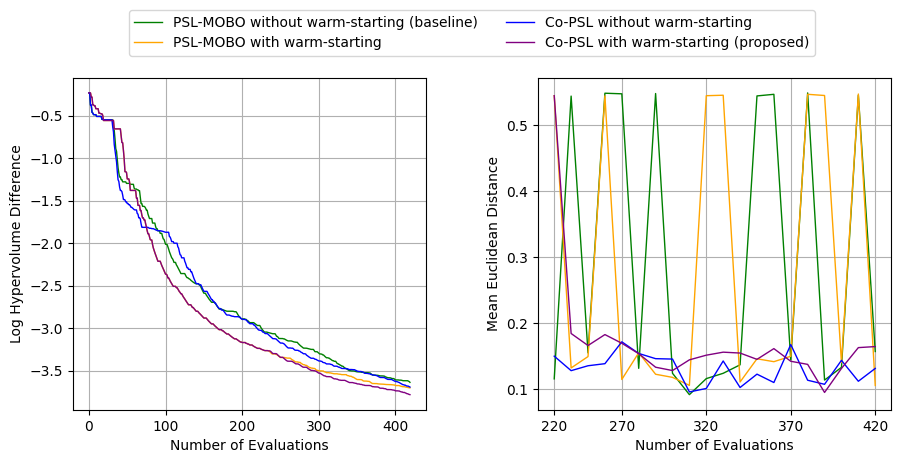

In [16]:
list_id = ['PSL-MOBO_nowarmstart', 'PSL-MOBO_warmstart', 'Co-PSL_nowarmstart', 'Co-PSL_warmstart']
label_id = ['PSL-MOBO without warm-starting (baseline)', 'PSL-MOBO with warm-starting', 'Co-PSL without warm-starting', 'Co-PSL with warm-starting (proposed)']
color_code = ['green', 'orange', 'blue', 'purple']
log_dir = "logs_DTLZ2_fig5"
title = "final"
Ablation_study_DTLZ2(list_id = list_id, label_id = label_id, log_dir = log_dir, problem_name = "DTLZ2", n_dim = 6, title = title, n_iter = 20, start = 0, stop = 420, color_code = color_code)